In [541]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install statsmodels

     |████████████████████████████████| 9.6 MB 2.2 MB/s            
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)


In [542]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from collections import Counter
from abc import ABC, abstractmethod
from scipy.stats import norm, beta
import seaborn as sns
import statsmodels.api as sm

/Users/rubenmak/Projects/time-robust-bandits/venv/time-robust-bandits/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [470]:
%load_ext autoreload
%autoreload 2
from bandits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time Robust Bandits
First, we will show the issue. In case of a parallel trend or shift, i.e. the expected reward of all arms increases at a specific moment or over time, several issues arise when not accounting for this.

In this example we assume a binary reward, but the effect occurs for any distrubution of the reward.

We therefore define the distribution of rewards of arm $a$ at time $t$ as follows: 
\
$r_{a, t} \sim Bernoulli(p_{a, t})$ \
$p_{a, t} = p^{a}_a + p^{t}_t$ \
\
Where:
* $p^{a}_a$ is the arm-specific reward, constant over time
* $p^{t}_t$ is the time-specific reward, equal for all arms


/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:96: RuntimeWarning: invalid value encountered in true_divide
  self.p = self.cum_rewards / self.cum_draws
/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:97: RuntimeWarning: divide by zero encountered in true_divide
  self.p_stderr = (1 / np.sqrt(self.cum_draws)) * np.sqrt(self.p * (1 - self.p))


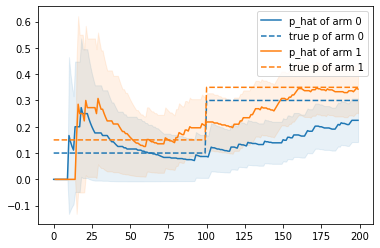

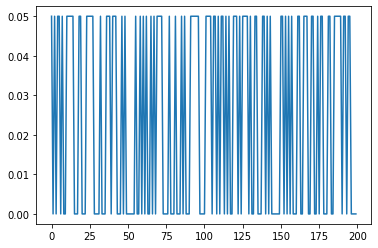

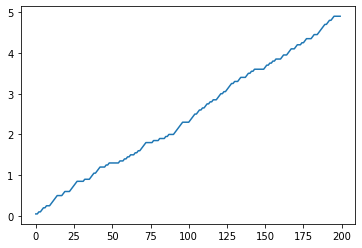

/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:139: RuntimeWarning: invalid value encountered in true_divide
  t_value = mean_diff[:, arm] / stderr_diff[:, arm]


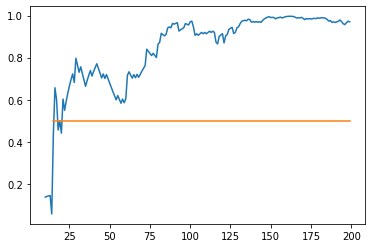

/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:139: RuntimeWarning: invalid value encountered in true_divide
  t_value = mean_diff[:, arm] / stderr_diff[:, arm]


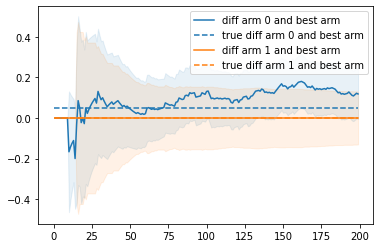

In [425]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15],
                        structural_reward = [0] * 100 + [0.2] * 100,
                        n_draws_per_time = 1)

ABTest = ABTestPolicy()

ABTestResult = Env.run_simulation(ABTest)
ABTestResult.plot_p()
plt.show()
ABTestResult.plot_regret()
plt.show()
ABTestResult.plot_cum_regret()
plt.show()
ABTestResult.plot_prob_best()
plt.show()
ABTestResult.plot_diff_best()

In [531]:
class ThompsonSamplingPolicy(BanditPolicy):
    
    def __init__(self, a_prior:int = 1, b_prior:int = 1, n_samples:int = 1000, p_random_holdout = 0):
        self.a_prior = a_prior
        self.b_prior = b_prior
        self.n_samples = n_samples
        self.p_random_holdout = p_random_holdout

    def calculate_arm_sample_probs(self, draws: np.array, rewards: np.array) -> np.array:
        '''
        Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative
        Returns am array of arm_sample_probs of size n_arms (which is the length of draws and rewards)
        '''
        if len(draws.shape) != 2 or len(rewards.shape) != 2:
            raise ValueError('Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative')
        if draws.shape != rewards.shape:
            raise ValueError('Shape of draws not equal to length of rewards')
            
        draws = np.sum(draws, axis = 0)
        rewards =  np.sum(rewards, axis = 0) 
        
        n_arms = len(draws)
        a = self.a_prior + rewards
        b = self.b_prior + draws - rewards
        arm_sample_probs = np.zeros(n_arms)
        
        beta_samples = np.zeros((self.n_samples, n_arms))
        for arm in range(n_arms):
            beta_samples[:, arm] = beta.rvs(a[arm], b[arm], size = self.n_samples)
        
        arm_wins = np.argmax(beta_samples, axis = 1)
        arm_wins = Counter(arm_wins)
        for arm in arm_wins:
            arm_sample_probs[arm] = arm_wins[arm] / self.n_samples
            
        arm_sample_probs += self.p_random_holdout / n_arms
        arm_sample_probs = arm_sample_probs / sum(arm_sample_probs)
        
        return arm_sample_probs

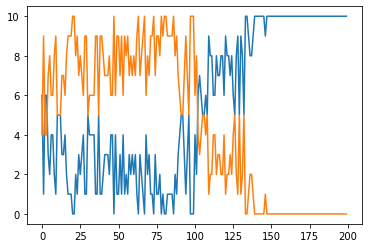

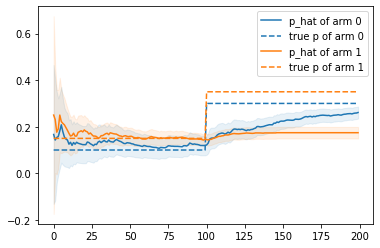

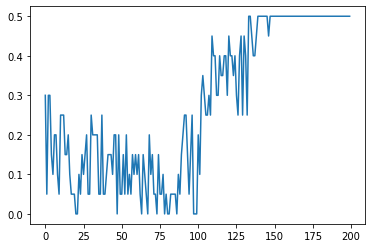

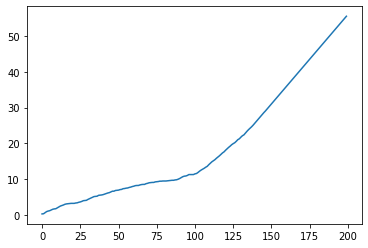

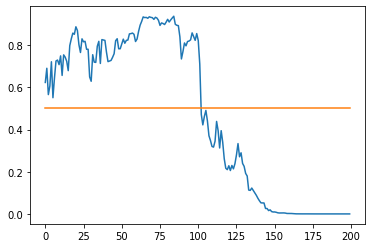

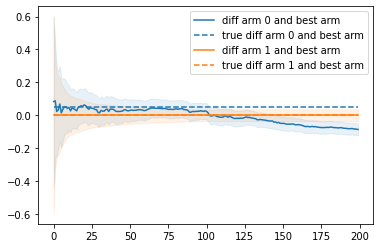

In [532]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15],
                        structural_reward = [0] * 100 + [0.2] * 100,
                        n_draws_per_time = 10)

ThompsonSampler = ThompsonSamplingPolicy()

TSResult = Env.run_simulation(ThompsonSampler)

TSResult.plot_draws()
plt.show()
TSResult.plot_p()
plt.show()
TSResult.plot_regret()
plt.show()
TSResult.plot_cum_regret()
plt.show()
TSResult.plot_prob_best()
plt.show()
TSResult.plot_diff_best()
plt.show()

/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:139: RuntimeWarning: invalid value encountered in true_divide
  t_value = mean_diff[:, arm] / stderr_diff[:, arm]


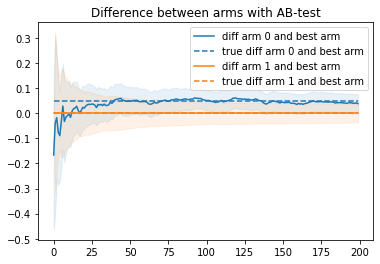

/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/2709452349.py:139: RuntimeWarning: invalid value encountered in true_divide
  t_value = mean_diff[:, arm] / stderr_diff[:, arm]


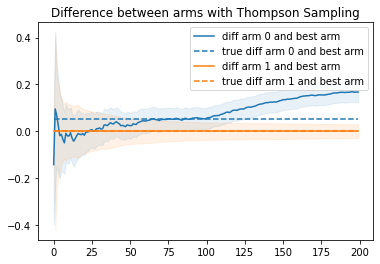

In [428]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15],
                        structural_reward = [0] * 100 + [0.2] * 100,
                        n_draws_per_time = 10)

ABTest = ABTestPolicy()
ABTestResult = Env.run_simulation(ABTest)
ABTestResult.plot_diff_best()
plt.title('Difference between arms with AB-test')
plt.show()

ThompsonSampler = ThompsonSamplingPolicy()
TSResult = Env.run_simulation(ThompsonSampler)
TSResult.plot_diff_best()
plt.title('Difference between arms with Thompson Sampling')
plt.show()

# Problem with structural shifts
* The problem is illustrated above: a positive structural shifts results in overestimation of the improvement caused by the winning arm. Therefore this is a problem of cause inference.
* It is trivial why calculations of probablity of the winner being better are also optmistically biased.
* We will now show the same holds with a positive trend.

# Illustration of problem with time trend as structural shift

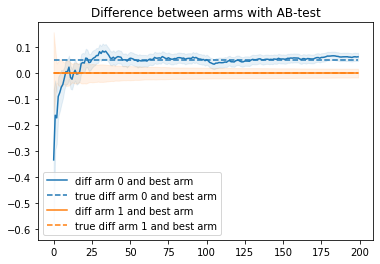

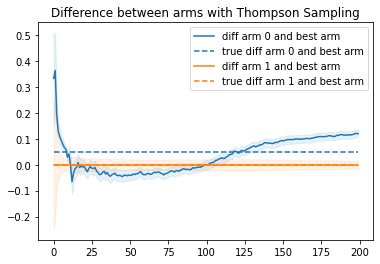

In [272]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15],
                        structural_reward = np.arange(0.0, 0.2, 0.001),
                        n_draws_per_time = 10)

ABTest = ABTestPolicy()
ABTestResult = Env.run_simulation(ABTest)
ABTestResult.plot_diff_best()
plt.title('Difference between arms with AB-test')
plt.show()

ThompsonSampler = ThompsonSamplingPolicy()
TSResult = Env.run_simulation(ThompsonSampler)
TSResult.plot_diff_best()
plt.title('Difference between arms with Thompson Sampling')
plt.show()

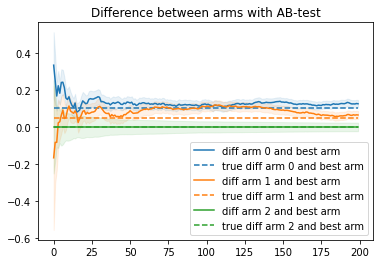

/var/folders/yg/lmz25_151h90wtbcfrdqjgjm0000gn/T/ipykernel_22363/3687982758.py:128: RuntimeWarning: invalid value encountered in true_divide
  t_value = mean_diff[:, arm] / stderr_diff[:, arm]


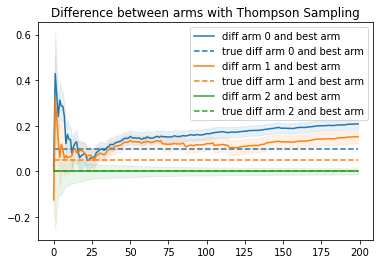

In [271]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15, 0.2],
                        structural_reward = np.arange(0.0, 0.2, 0.001),
                        n_draws_per_time = 10)

ABTest = ABTestPolicy()
ABTestResult = Env.run_simulation(ABTest)
ABTestResult.plot_diff_best()
plt.title('Difference between arms with AB-test')
plt.show()

ThompsonSampler = ThompsonSamplingPolicy()
TSResult = Env.run_simulation(ThompsonSampler)
TSResult.plot_diff_best()
plt.title('Difference between arms with Thompson Sampling')
plt.show()

# How does this effect regret?
* In scenarios where a arm different from the best arm gets most draws, overestimation results in another problem. Because of overestimation, the subotopimal arm might seem to be optimal for an inefficiently long time.

In [660]:
def simulate_regret(Envs: list, Policies: list, n_runs: int = 100) -> List[List[np.array]]:
    '''
    Input Envs is a list of objects of BanditEnvironment class.
    Input Policies is a list of objects of BanditPolicy class.
    Returns a list of len(Envs) containting lists of len(Policies) contain np.arrays of size (n_times, n_tuns)
    '''
    sim_regret = np.zeros((len(Envs), len(Policies), n_times, n_runs))
    for r in range(n_runs):
        for e in range(len(Envs)):
            for p in range(len(Policies)):
                Result = Envs[e].run_simulation(Policies[p])
                sim_regret[e, p, :, r] = Result.regret
                
    return sim_regret


def plot_regret_comparison(sim_regret: np.array, Env_label: List[str], Policy_label: List[str], compare_policies: bool = True) -> None:
    '''
    Input sim_regret is a np.array of size (len(Envs), en(Policies), n_times, n_runs)
    compare_policies = True plots the different policies inside the same plot, one plot for each environment.
    compare_policies = False plots the different environments inside the same plot, one plot for each policy.
    '''
    n_envs = sim_regret.shape[0]
    n_policies = sim_regret.shape[1]
    n_times = sim_regret.shape[2]
    n_runs = sim_regret.shape[3]
    
    if compare_policies:
        for e in range(n_envs):
            regret = [sim_regret[e, p, :, :].reshape((n_times, n_runs)) for p in range(n_policies)] 
            plot_with_ci(regret, label=Policy_label)
            plt.title('Regret in {} Environment'.format(Env_label[e]))
            plt.show()
        for e in range(n_envs):
            cum_regret = [np.cumsum(sim_regret[e, p, :, :].reshape((n_times, n_runs)), axis = 0) for p in range(n_policies)] 
            plot_with_ci(cum_regret, label=Policy_label)
            plt.title('Cumulative Regret {} Environment'.format(Env_label[e]))
            plt.show()
    else:
        for p in range(n_policies):
            regret = [sim_regret[e, p, :, :].reshape((n_times, n_runs)) for e in range(n_envs)] 
            plot_with_ci(regret, label=Env_label)
            plt.title('{} Regret '.format(Policy_label[p]))
            plt.show()
        for p in range(n_policies):
            cum_regret = [np.cumsum(sim_regret[e, p, :, :].reshape((n_times, n_runs)), axis = 0) for e in range(n_envs)] 
            plot_with_ci(cum_regret, label=Env_label)
            plt.title('{} Cumulative Regret'.format(Policy_label[p]))
            plt.show()
    

def plot_final_cum_regret(sim_regret: np.array, Env_label: List[str], Policy_label: List[str]) -> None:
    '''
    Input sim_regret is a np.array of size (len(Envs), en(Policies), n_times, n_runs)
    '''
    n_envs = sim_regret.shape[0]
    n_policies = sim_regret.shape[1]
    n_times = sim_regret.shape[2]
    n_runs = sim_regret.shape[3]
    
    for e in range(n_envs):
        for p in range(n_policies):
            cum_regret = np.cumsum(sim_regret[e, p, :, :].reshape((n_times, n_runs)), axis = 0)
            sns.displot(cum_regret[-1, :])
            plt.title('{} Regret in last time step in {} env'.format(Policy_label[p], Env_label[e]))

In [661]:
arm_rewards = [0.1, 0.15, 0.2]

unstable_structural_reward = [0] * 10 + [0.2] * 390
n_times = len(unstable_structural_reward)
stable_structural_reward = [np.mean(unstable_structural_reward)] * n_times

n_draws_per_time = 10

UnstableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = unstable_structural_reward,
                        n_draws_per_time = n_draws_per_time)

StableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = stable_structural_reward,
                        n_draws_per_time = n_draws_per_time)


ThompsonSampler = ThompsonSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler])

/Users/rubenmak/Projects/time-robust-bandits/notebooks/bandits.py:95: RuntimeWarning: invalid value encountered in true_divide
  self.p = self.cum_rewards / self.cum_draws
/Users/rubenmak/Projects/time-robust-bandits/notebooks/bandits.py:96: RuntimeWarning: divide by zero encountered in true_divide
  self.p_stderr = (1 / np.sqrt(self.cum_draws)) * np.sqrt(self.p * (1 - self.p))


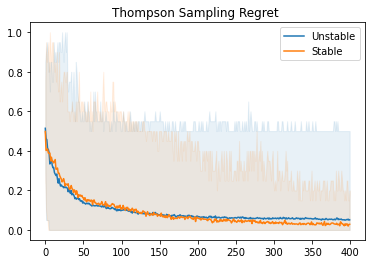

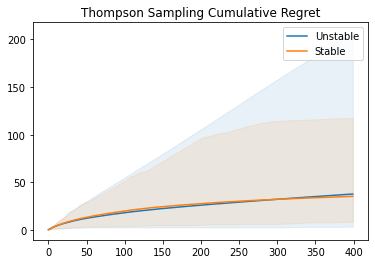

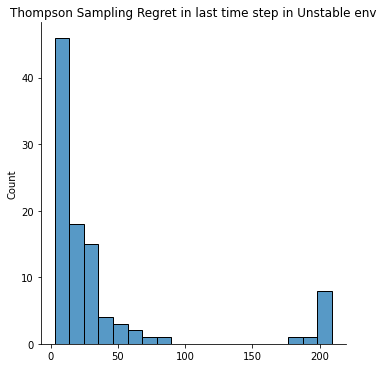

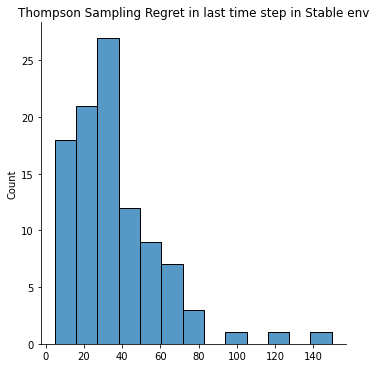

In [662]:
plot_regret_comparison(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling'], compare_policies = False)
plot_final_cum_regret(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling'])

In [663]:
arm_rewards = [0.1, 0.15]

unstable_structural_reward = [0] * 10 + [0.2] * 390
n_times = len(unstable_structural_reward)
stable_structural_reward = [np.mean(unstable_structural_reward)] * n_times

n_draws_per_time = 10

UnstableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = unstable_structural_reward,
                        n_draws_per_time = n_draws_per_time)

StableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = stable_structural_reward,
                        n_draws_per_time = n_draws_per_time)


ThompsonSampler = ThompsonSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler])

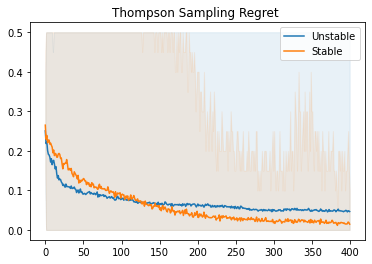

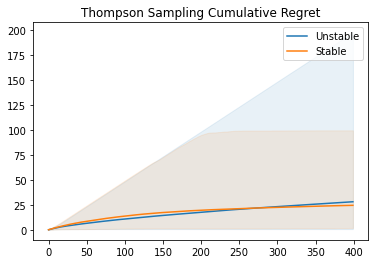

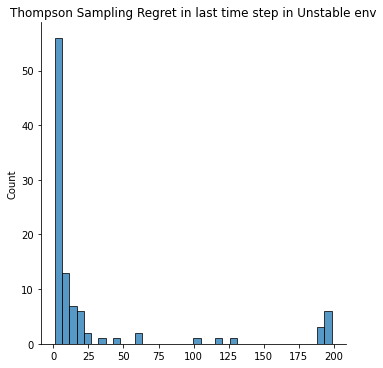

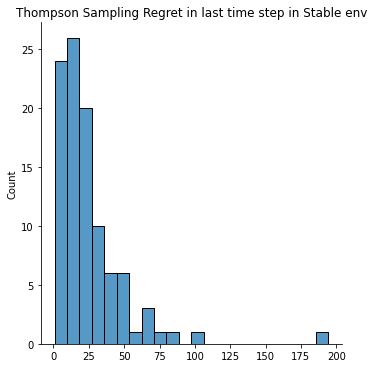

In [664]:
plot_regret_comparison(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling'], compare_policies = False)
plot_final_cum_regret(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling'])

# Create a time robust policy using differences instead of absolute values

In [665]:
class TimeRobustSamplingPolicy(BanditPolicy):
    
    def __init__(self, a_prior:int = 0.1, b_prior:int = 0.1, n_samples:int = 1000):
        self.a_prior = a_prior
        self.b_prior = b_prior
        self.n_samples = n_samples

    def calculate_arm_sample_probs(self, draws: np.array, rewards: np.array) -> np.array:
        '''
        Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative
        Returns am array of arm_sample_probs of size n_arms (which is the length of draws and rewards)
        '''
        if len(draws.shape) != 2 or len(rewards.shape) != 2:
            raise ValueError('Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative')
        if draws.shape != rewards.shape:
            raise ValueError('Shape of draws not equal to length of rewards')
        
        n_arms = draws.shape[1]
        n_times = draws.shape[0]
        reward = rewards + self.a_prior
        draw = draws + self.a_prior + self.b_prior
        
        p = reward / draw
        stderr_p = 1 / np.sqrt(draw) * np.sqrt(p * (1-p))
        
        arm_sample_probs = np.zeros(n_arms)
        norm_samples = np.zeros((self.n_samples, n_arms))
        
        for arm in range(n_arms):
            mean_diff = np.mean(np.tile(p[:, arm], (n_arms - 1, 1)).T - np.delete(p, arm, axis = 1))
            stderr_vars = np.square(np.tile(stderr_p[:, arm], (n_arms - 1, 1)).T) + np.square(np.delete(p, arm, axis = 1))
            stderr_diff = np.sqrt(np.mean(stderr_vars) / n_times) 
            norm_samples[:, arm] = norm.rvs(mean_diff, stderr_diff, size = self.n_samples)
        
        arm_wins = np.argmax(norm_samples, axis = 1)
        arm_wins = Counter(arm_wins)
        for arm in arm_wins:
            arm_sample_probs[arm] = arm_wins[arm] / self.n_samples
        
        return arm_sample_probs

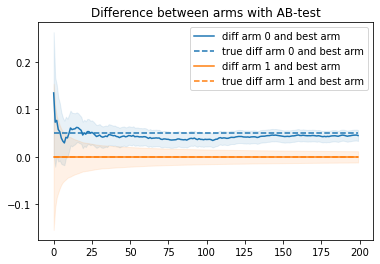

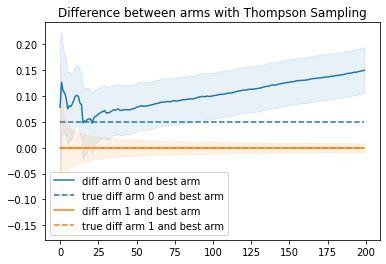

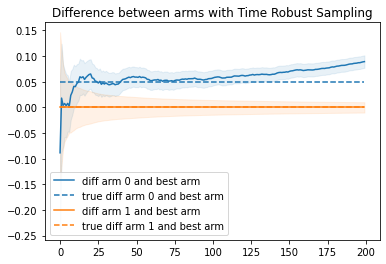

In [666]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15],
                        structural_reward = np.arange(0.0, 0.2, 0.001),
                        n_draws_per_time = 100)

ABTest = ABTestPolicy()
ABTestResult = Env.run_simulation(ABTest)
ABTestResult.plot_diff_best()
plt.title('Difference between arms with AB-test')
plt.show()

ThompsonSampler = ThompsonSamplingPolicy()
TSResult = Env.run_simulation(ThompsonSampler)
TSResult.plot_diff_best()
plt.title('Difference between arms with Thompson Sampling')
plt.show()

TimeRobustSampler = TimeRobustSamplingPolicy()
TBResult = Env.run_simulation(TimeRobustSampler)
TBResult.plot_diff_best()
plt.title('Difference between arms with Time Robust Sampling')
plt.show()

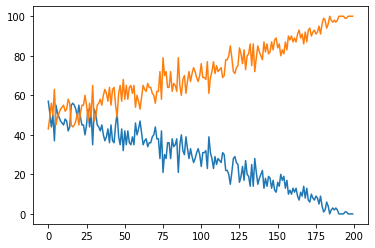

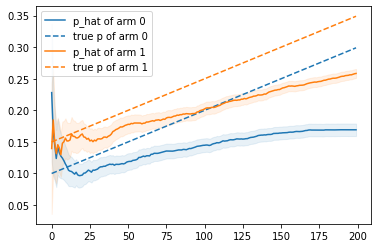

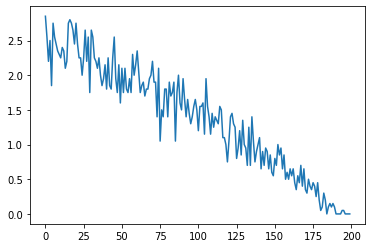

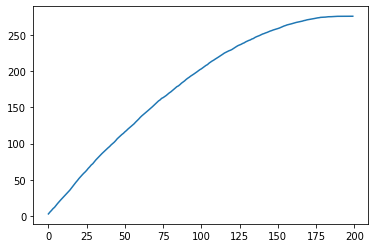

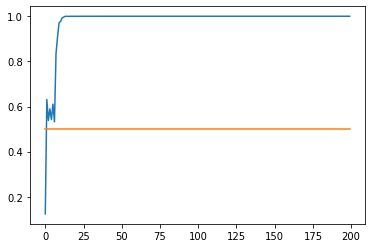

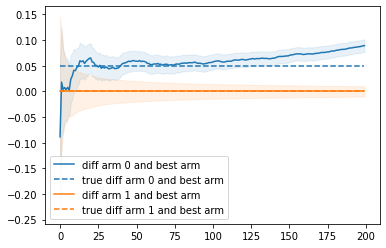

In [667]:
TBResult.plot_draws()
plt.show()
TBResult.plot_p()
plt.show()
TBResult.plot_regret()
plt.show()
TBResult.plot_cum_regret()
plt.show()
TBResult.plot_prob_best()
plt.show()
TBResult.plot_diff_best()
plt.show()

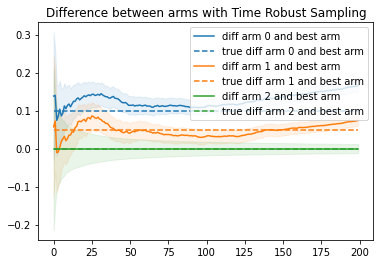

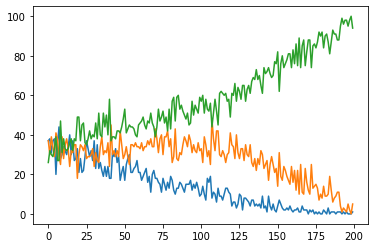

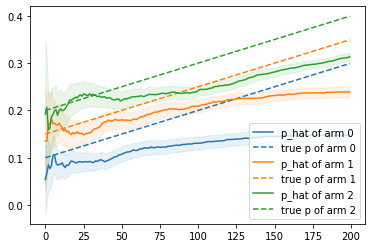

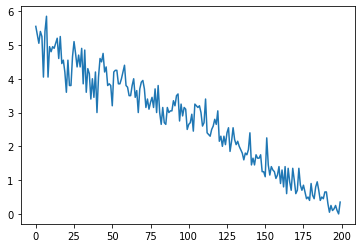

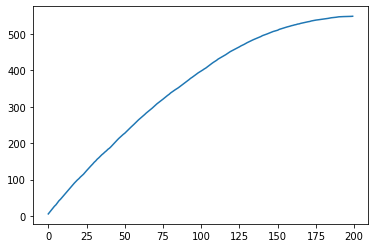

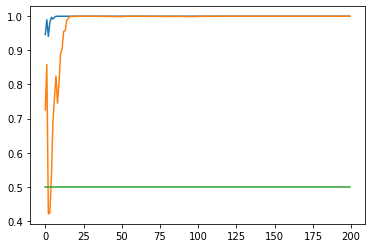

In [668]:
Env = BanditEnvironment(arm_rewards = [0.1, 0.15, 0.2],
                        structural_reward = np.arange(0.0, 0.2, 0.001),
                        n_draws_per_time = 100)

TimeRobustSampler = TimeRobustSamplingPolicy()
TBResult = Env.run_simulation(TimeRobustSampler)
TBResult.plot_diff_best()
plt.title('Difference between arms with Time Robust Sampling')
plt.show()
TBResult.plot_draws()
plt.show()
TBResult.plot_p()
plt.show()
TBResult.plot_regret()
plt.show()
TBResult.plot_cum_regret()
plt.show()
TBResult.plot_prob_best()
plt.show()

In [669]:
arm_rewards = [0.1, 0.15]

unstable_structural_reward = [0] * 10 + [0.2] * 390
n_times = len(unstable_structural_reward)
stable_structural_reward = [np.mean(unstable_structural_reward)] * n_times

n_draws_per_time = 10

UnstableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = unstable_structural_reward,
                        n_draws_per_time = n_draws_per_time)

StableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = stable_structural_reward,
                        n_draws_per_time = n_draws_per_time)


TimeRobustSampler = TimeRobustSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [TimeRobustSampler])

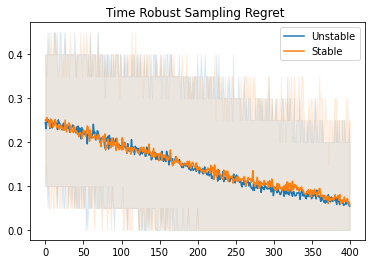

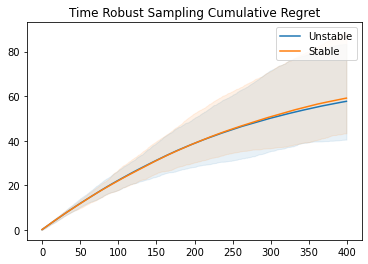

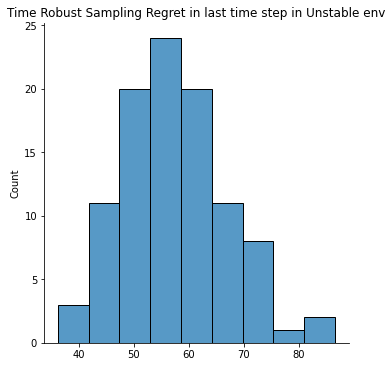

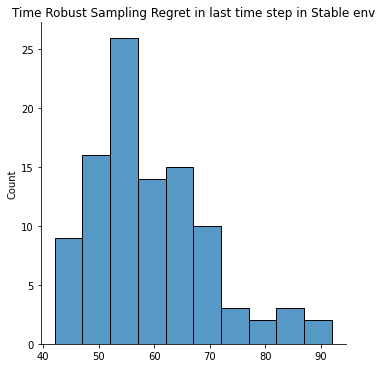

In [670]:
plot_regret_comparison(sim_regret, ['Unstable', 'Stable'], ['Time Robust Sampling'], compare_policies = False)
plot_final_cum_regret(sim_regret, ['Unstable', 'Stable'], ['Time Robust Sampling'])

# Compare various policies in structural break env

In [671]:
arm_rewards = [0.1, 0.15]

unstable_structural_reward = [0] * 10 + [0.3] * 390
n_times = len(unstable_structural_reward)
stable_structural_reward = [np.mean(unstable_structural_reward)] * n_times

n_draws_per_time = 10

UnstableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = unstable_structural_reward,
                        n_draws_per_time = n_draws_per_time)

StableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = stable_structural_reward,
                        n_draws_per_time = n_draws_per_time)


ThompsonSampler = ThompsonSamplingPolicy()
TimeRobustSampler = TimeRobustSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, TimeRobustSampler])

/Users/rubenmak/Projects/time-robust-bandits/notebooks/bandits.py:95: RuntimeWarning: invalid value encountered in true_divide
  self.p = self.cum_rewards / self.cum_draws
/Users/rubenmak/Projects/time-robust-bandits/notebooks/bandits.py:96: RuntimeWarning: divide by zero encountered in true_divide
  self.p_stderr = (1 / np.sqrt(self.cum_draws)) * np.sqrt(self.p * (1 - self.p))


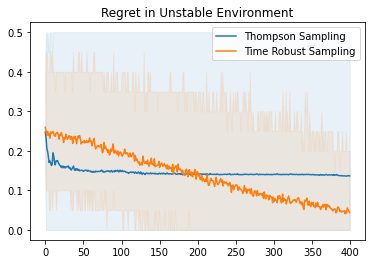

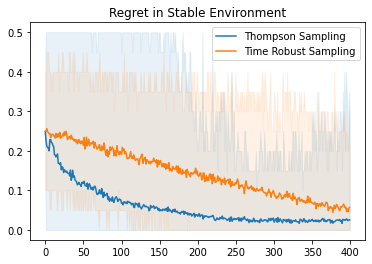

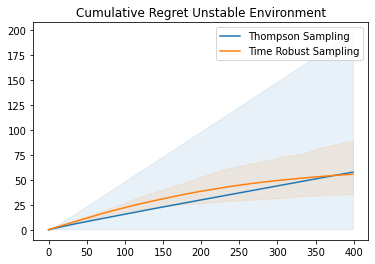

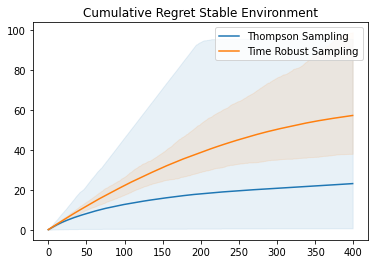

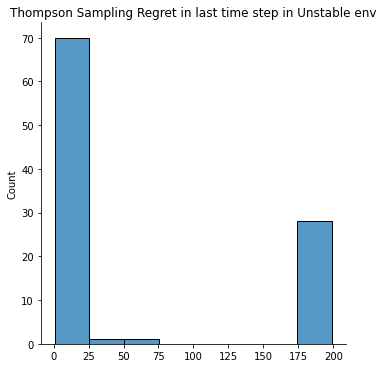

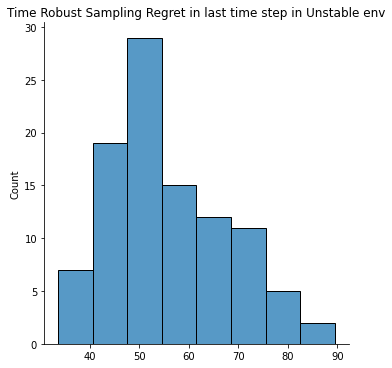

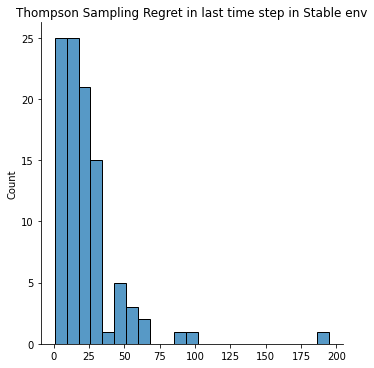

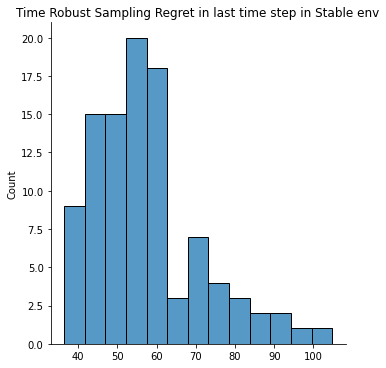

In [672]:
plot_regret_comparison(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling', 'Time Robust Sampling'])
plot_final_cum_regret(sim_regret, ['Unstable', 'Stable'], ['Thompson Sampling', 'Time Robust Sampling'])

In [673]:
ThompsonSampler = ThompsonSamplingPolicy()
ThompsonSampler_StrongPrior = ThompsonSamplingPolicy(a_prior = 500, b_prior = 500)

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, ThompsonSampler_StrongPrior])

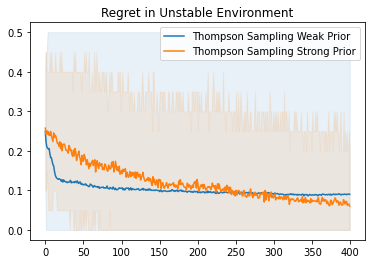

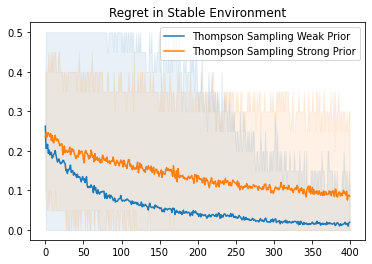

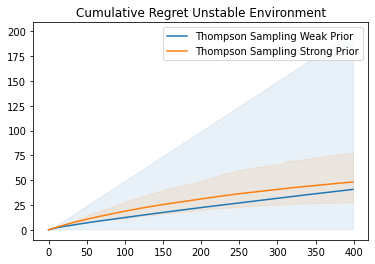

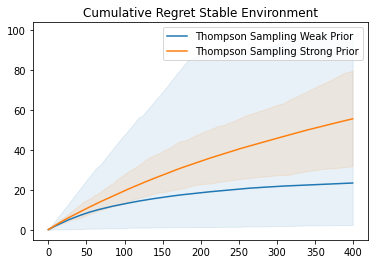

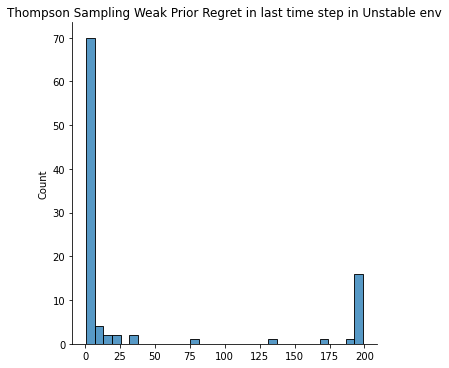

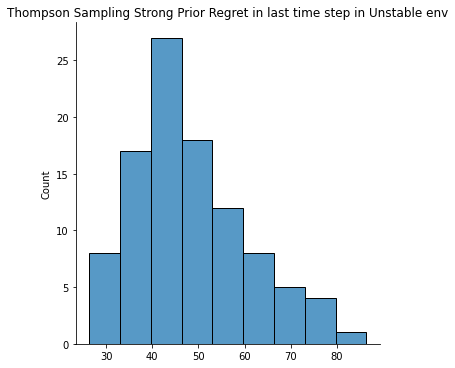

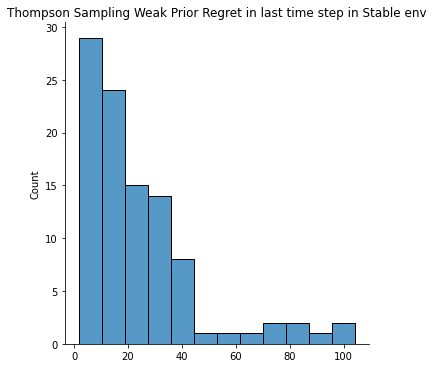

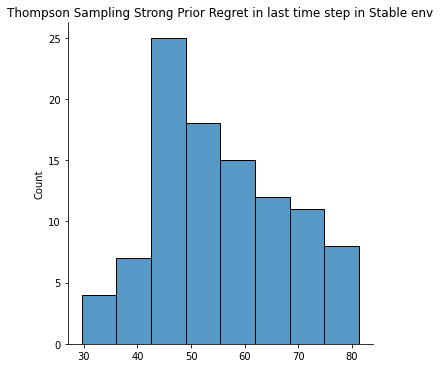

In [674]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling Weak Prior', 'Thompson Sampling Strong Prior']
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)

In [675]:
p_holdout = 0.1
ThompsonSampler = ThompsonSamplingPolicy()
ThompsonSampler_Holdout = ThompsonSamplingPolicy(p_random_holdout = p_holdout)

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, ThompsonSampler_Holdout])

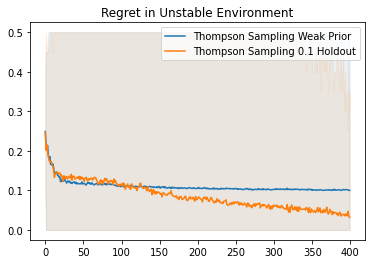

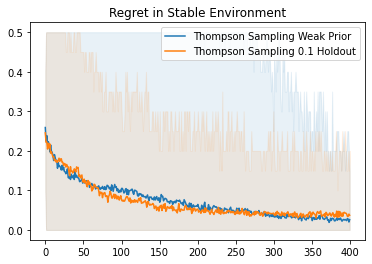

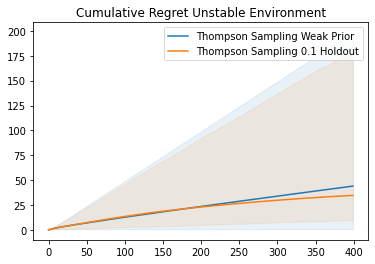

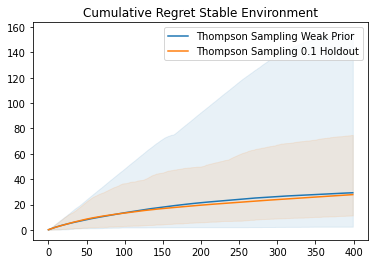

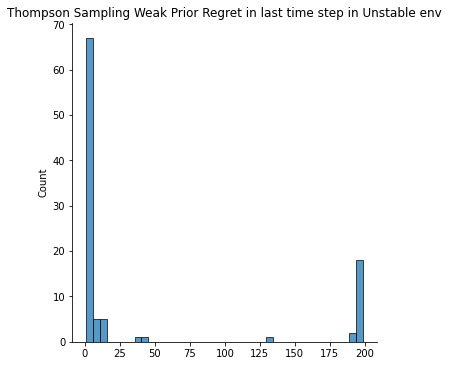

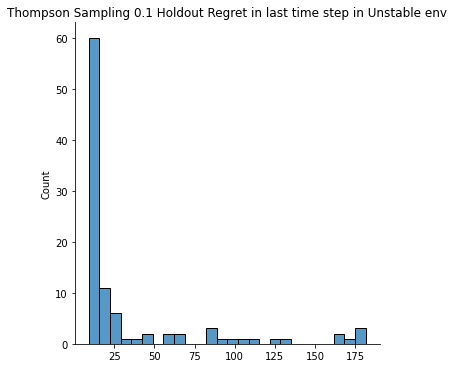

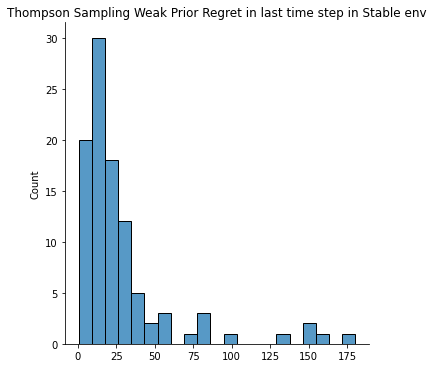

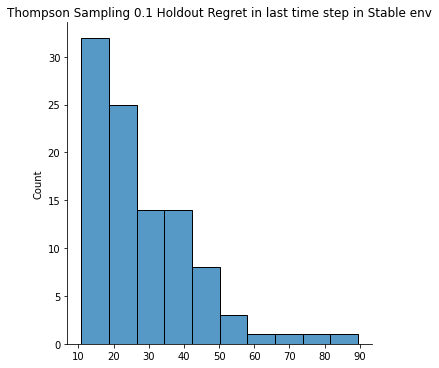

In [676]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling Weak Prior', 'Thompson Sampling {} Holdout'.format(p_holdout)]
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)

# Analysis for various solutions in time trend env

In [677]:
arm_rewards = [0.1, 0.15]

unstable_structural_reward = np.arange(0.0, 0.3, 0.001)
n_times = len(unstable_structural_reward)
stable_structural_reward = [np.mean(unstable_structural_reward)] * n_times

n_draws_per_time = 10

UnstableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = unstable_structural_reward,
                        n_draws_per_time = n_draws_per_time)

StableEnv = BanditEnvironment(arm_rewards = arm_rewards,
                        structural_reward = stable_structural_reward,
                        n_draws_per_time = n_draws_per_time)


ThompsonSampler = ThompsonSamplingPolicy()
TimeRobustSampler = TimeRobustSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, TimeRobustSampler])

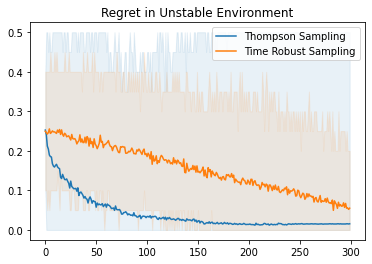

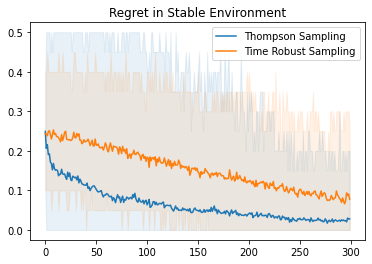

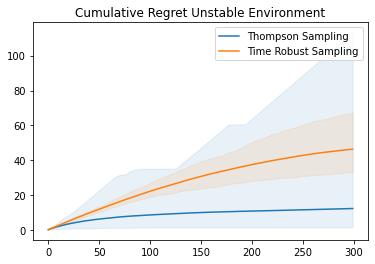

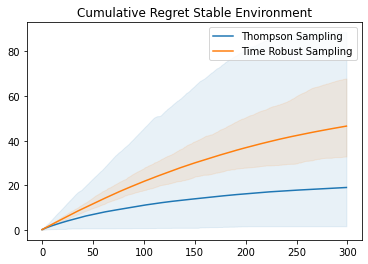

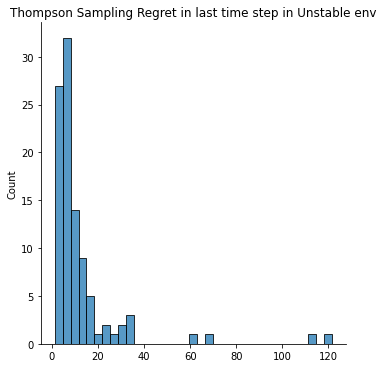

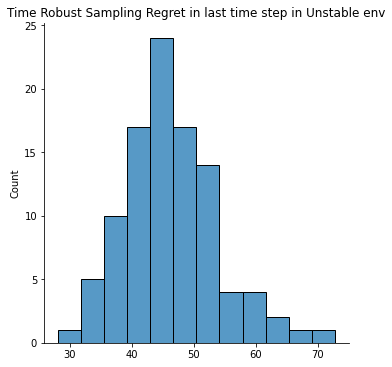

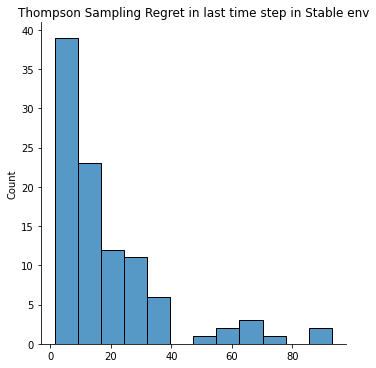

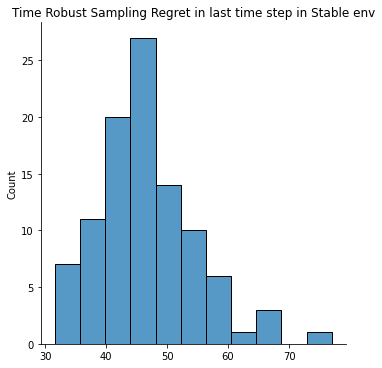

In [678]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling', 'Time Robust Sampling']
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)

In [679]:
ThompsonSampler = ThompsonSamplingPolicy()
ThompsonSampler_StrongPrior = ThompsonSamplingPolicy(a_prior = 500, b_prior = 500)

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, ThompsonSampler_StrongPrior])

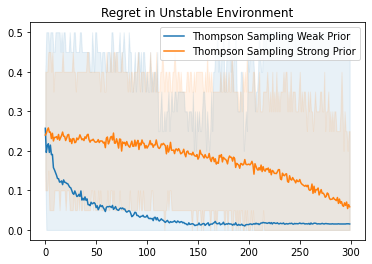

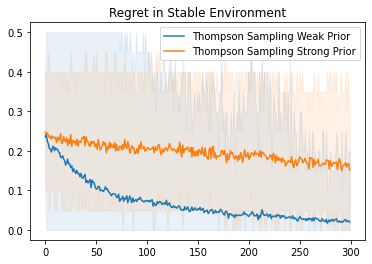

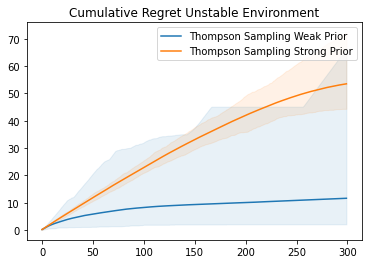

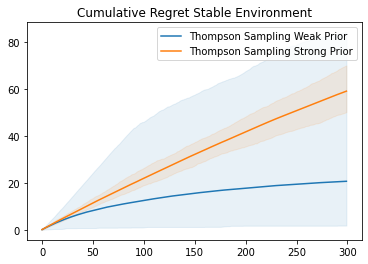

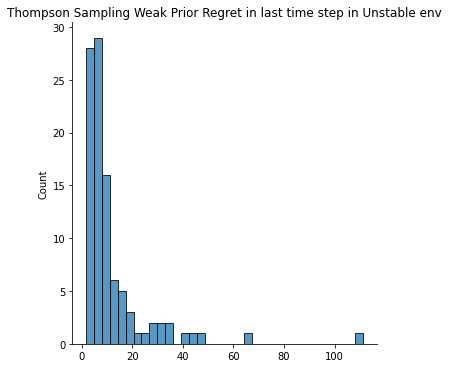

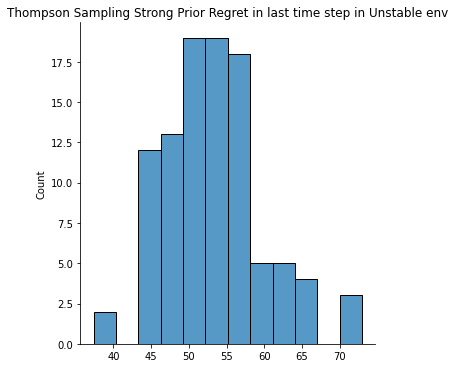

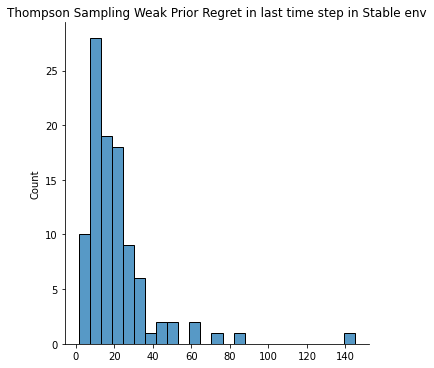

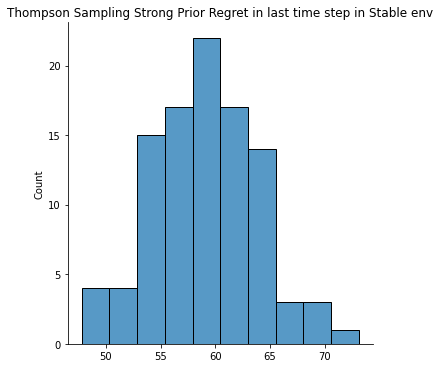

In [680]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling Weak Prior', 'Thompson Sampling Strong Prior']
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)

In [681]:
p_holdout = 0.1
ThompsonSampler = ThompsonSamplingPolicy()
ThompsonSampler_Holdout = ThompsonSamplingPolicy(p_random_holdout = p_holdout)

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, ThompsonSampler_StrongPrior])

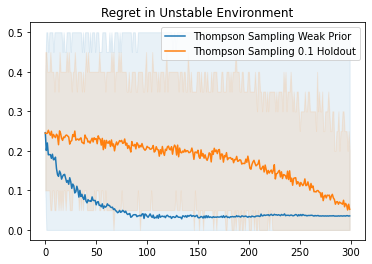

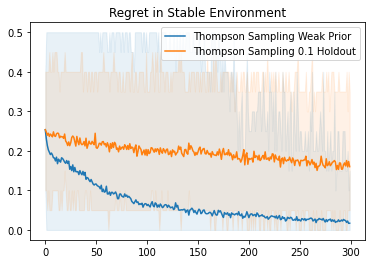

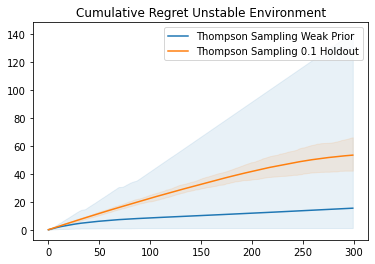

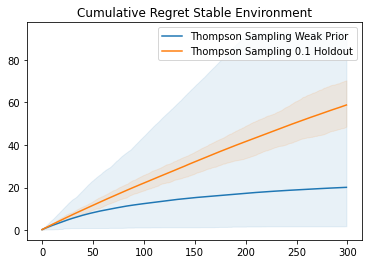

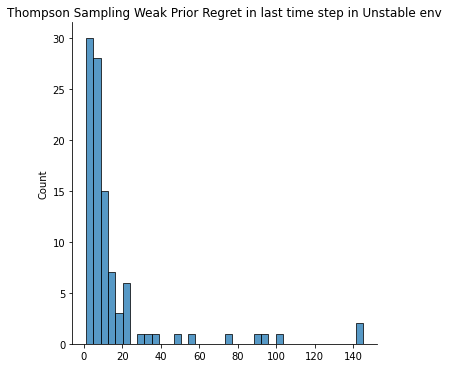

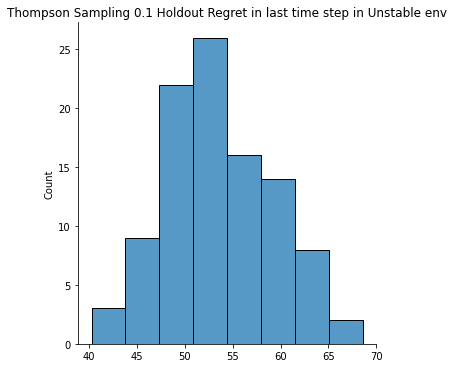

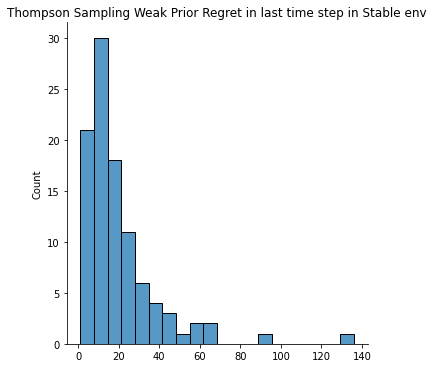

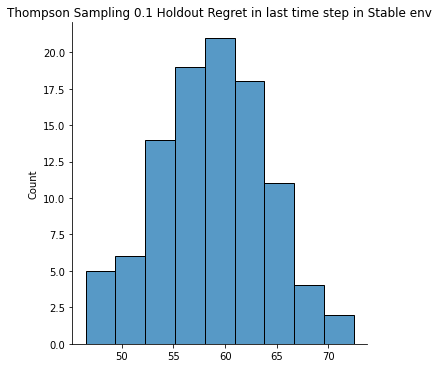

In [682]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling Weak Prior', 'Thompson Sampling {} Holdout'.format(p_holdout)]
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)

# Make Policy that specifically takes trend into account

In [683]:
class LinearTrendSamplingPolicy(BanditPolicy):
    
    def __init__(self, n_samples:int = 1000):
        self.n_samples = n_samples

    def calculate_arm_sample_probs(self, draws: np.array, rewards: np.array, print_results: bool = False) -> np.array:
        '''
        Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative
        Returns am array of arm_sample_probs of size n_arms (which is the length of draws and rewards)
        '''
        if len(draws.shape) != 2 or len(rewards.shape) != 2:
            raise ValueError('Both draws and rewards need to be 2 dimensional np.arrays of size (n_times, n_arms) and not cumulative')
        if draws.shape != rewards.shape:
            raise ValueError('Shape of draws not equal to length of rewards')
        
        n_arms = draws.shape[1]
        n_times = draws.shape[0]
        
        y = rewards.flatten()
        
        time = np.arange(n_times)
        time = np.tile(time, (n_arms, 1)).T.flatten()
        
        x = np.zeros((n_arms * n_times, n_arms))
        
        for t in range(n_times):
            for a in range(n_arms):
                x[ t * n_arms + a , a] = draws[t, a]
        
        x = np.concatenate((x, time.reshape((-1,1))), axis = 1)
        
        model = sm.OLS(y, x)
        results = model.fit()
        if print_results:
            print(results.summary())
        
        arm_sample_probs = np.zeros(n_arms)
        norm_samples = np.zeros((self.n_samples, n_arms))
        
        for arm in range(n_arms):
            mean_diff = results.params[arm]
            stderr_diff = np.sqrt(results.cov_params()[arm, arm])
            norm_samples[:, arm] = norm.rvs(mean_diff, stderr_diff, size = self.n_samples)
        
        arm_wins = np.argmax(norm_samples, axis = 1)
        arm_wins = Counter(arm_wins)
        for arm in arm_wins:
            arm_sample_probs[arm] = arm_wins[arm] / self.n_samples
        
        return arm_sample_probs

In [684]:
LinearTrend = LinearTrendSamplingPolicy()
LinearTrend.calculate_arm_sample_probs(LinearTrendResult_unstable.draws, LinearTrendResult_unstable.rewards, print_results = True)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.771
Method:                 Least Squares   F-statistic:                              672.5
Date:                Tue, 01 Feb 2022   Prob (F-statistic):                   5.89e-191
Time:                        17:48:13   Log-Likelihood:                         -895.68
No. Observations:                 600   AIC:                                      1797.
Df Residuals:                     597   BIC:                                      1811.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

array([0., 1.])

In [685]:
ThompsonSampler = ThompsonSamplingPolicy()
LinearTrend = LinearTrendSamplingPolicy()

sim_regret = simulate_regret([UnstableEnv, StableEnv], [ThompsonSampler, LinearTrend])

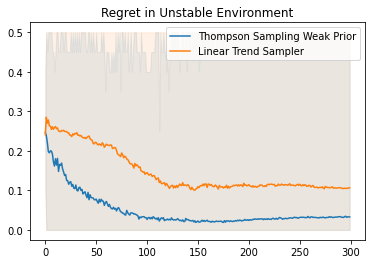

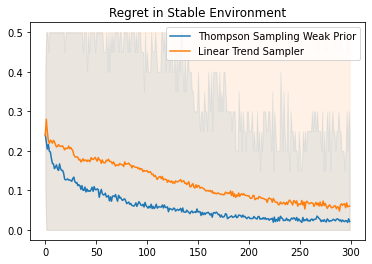

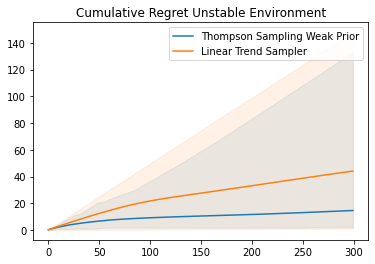

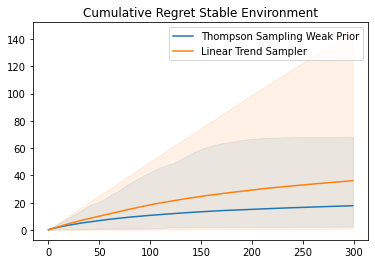

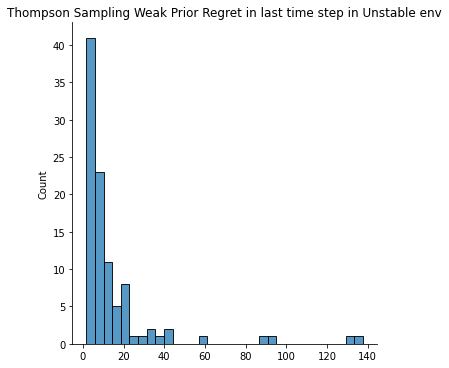

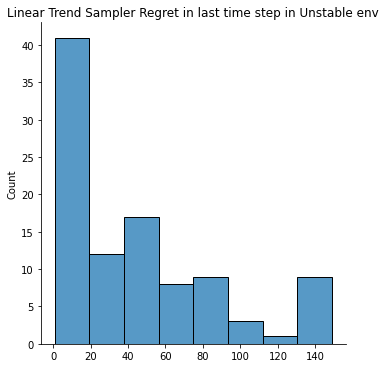

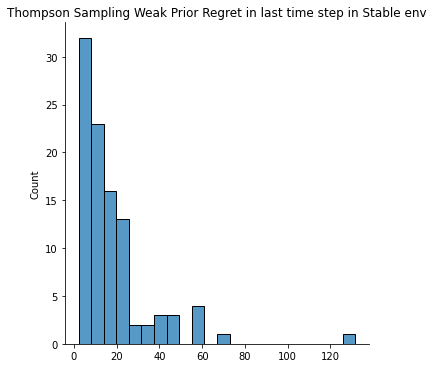

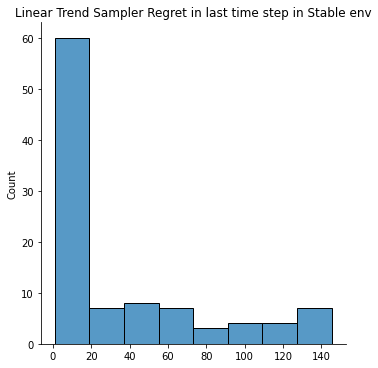

In [686]:
env_labels = ['Unstable', 'Stable']
policy_labels = ['Thompson Sampling Weak Prior', 'Linear Trend Sampler']
plot_regret_comparison(sim_regret, env_labels, policy_labels)
plot_final_cum_regret(sim_regret, env_labels, policy_labels)